In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

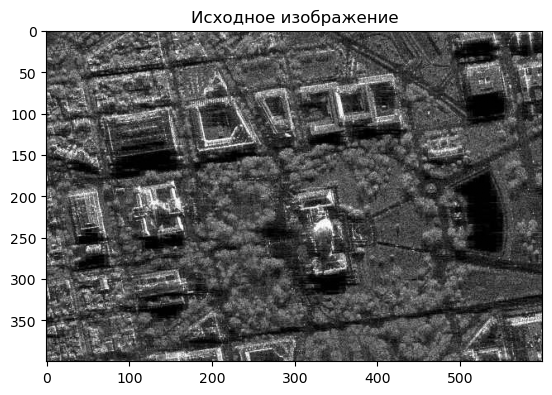

In [2]:
# 1. Загружаем изображение в оттенках серого sar_1_gray.jpg
img = cv2.imread('sar_1_gray.jpg', cv2.IMREAD_GRAYSCALE)  

plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.title('Исходное изображение')
plt.show()

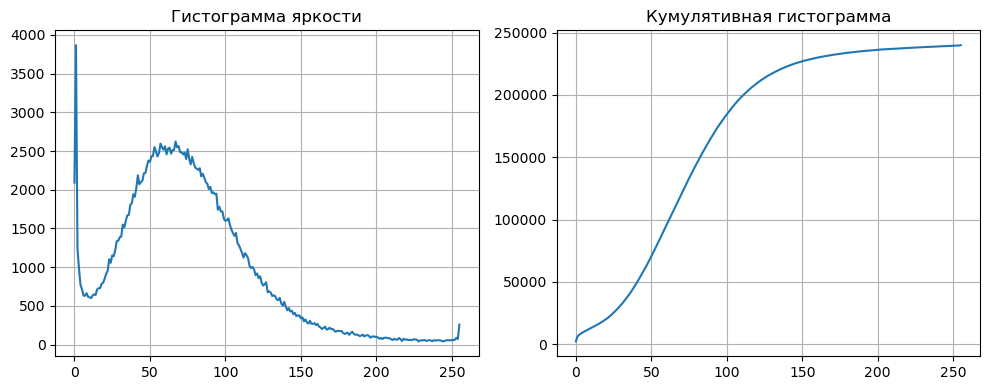

In [3]:
# 2. Построение гистограммы
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
cum_hist = hist.cumsum()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(hist)
axes[0].set_title('Гистограмма яркости')
axes[0].grid(True)

axes[1].plot(cum_hist)
axes[1].set_title('Кумулятивная гистограмма')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [4]:
# 3. Гамма-коррекция
def gamma_correction(gray_image: np.ndarray, gamma: float) -> np.ndarray:
    #Гамма-коррекция одноканального изображения
    norm = gray_image.astype(np.float32) / 255.0
    corrected = np.power(norm, gamma) * 255.0
    return np.clip(corrected, 0, 255).astype(np.uint8)

In [5]:
gammas = [0.5, 0.8, 1.2, 1.5]

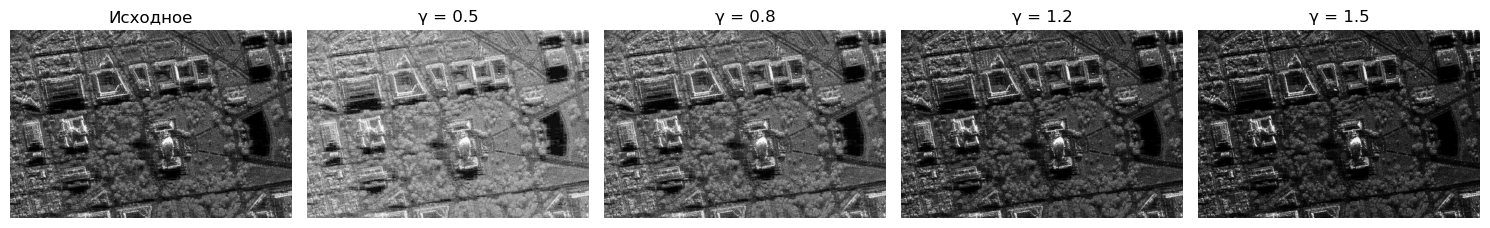

In [6]:
fig, axes = plt.subplots(1, len(gammas) + 1, figsize=(15, 4))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Исходное')
axes[0].axis('off')

for ax, g in zip(axes[1:], gammas):
    img_g = gamma_correction(img, g)
    ax.imshow(img_g, cmap='gray', vmin=0, vmax=255)
    ax.set_title(f'γ = {g}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# 4. Сравнение изображений (MSE и SSIM)
def mse(img1: np.ndarray, img2: np.ndarray) -> float:
    #Среднеквадратичная ошибка между изображениями
    return np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)

In [8]:
def compare_with_gamma(original: np.ndarray, gamma_values):
    #Выводит MSE и SSIM для разных значений гаммы
    for g in gamma_values:
        processed = gamma_correction(original, g)
        m = mse(original, processed)
        s = ssim(original, processed, data_range=255)
        print(f"γ = {g:4.2f}  →  MSE = {m:10.2f},  SSIM = {s:6.3f}")

In [9]:
compare_with_gamma(img, gammas)

γ = 0.50  →  MSE =    3258.39,  SSIM =  0.788
γ = 0.80  →  MSE =     323.96,  SSIM =  0.960
γ = 1.20  →  MSE =     224.27,  SSIM =  0.957
γ = 1.50  →  MSE =     974.07,  SSIM =  0.806


In [10]:
# 5.Статистическая цветокоррекция
mean_src = img.mean()
std_src = img.std()

print(f"Исходное изображение: mean = {mean_src:.2f}, std = {std_src:.2f}")

Исходное изображение: mean = 74.94, std = 43.38


In [11]:
# целевая статистика по изображению после эквализации
eq_gray = cv2.equalizeHist(img)

mean_tgt = eq_gray.mean()
std_tgt = eq_gray.std()

print(f"eq_gray: mean = {mean_tgt:.2f}, std = {std_tgt:.2f}")

eq_gray: mean = 127.32, std = 74.09


In [12]:
# приведение
corrected = img.astype(np.float32)

if std_src > 1e-6:
    corrected = (corrected - mean_src) / std_src * std_tgt + mean_tgt
else:
    corrected[:] = mean_tgt  

corrected = np.clip(corrected, 0, 255).astype(np.uint8)

In [13]:
mean_corr = corrected.mean()
std_corr = corrected.std()

print(f"После коррекции: mean = {mean_corr:.2f}, std = {std_corr:.2f}")

После коррекции: mean = 123.44, std = 65.20


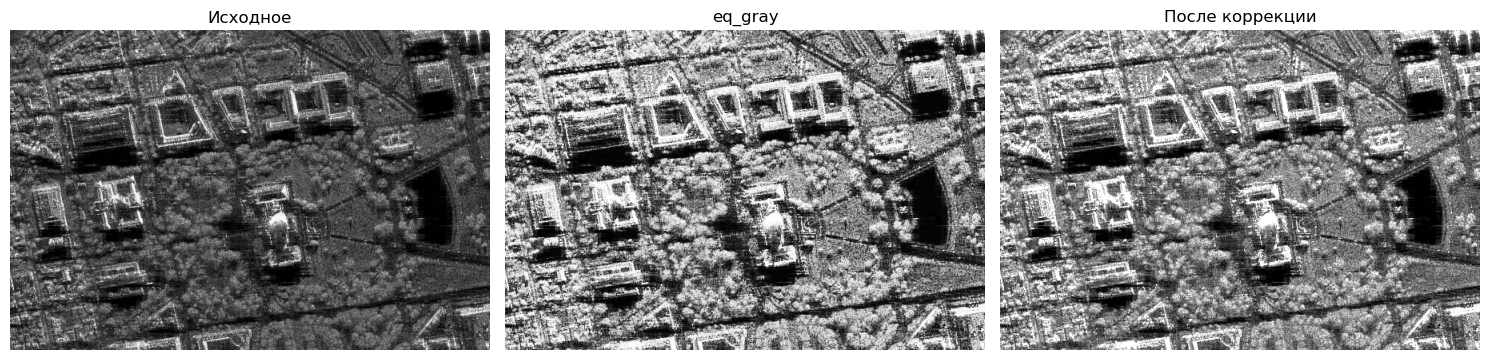

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].imshow(img, cmap='gray', vmin=0, vmax=255)
axes[0].set_title('Исходное')
axes[0].axis('off')

axes[1].imshow(eq_gray, cmap='gray', vmin=0, vmax=255)
axes[1].set_title('eq_gray')
axes[1].axis('off')

axes[2].imshow(corrected, cmap='gray', vmin=0, vmax=255)
axes[2].set_title('После коррекции')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# 6. Пороговая фильтрация
thresholds = [60, 90, 120, 150]

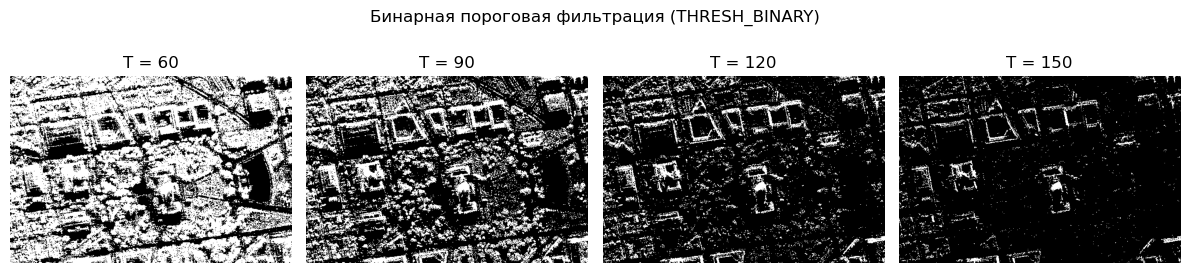

In [17]:
fig, axes = plt.subplots(1, len(thresholds), figsize=(12, 3))

for col, thr in enumerate(thresholds):
    _, th_bin = cv2.threshold(img, thr, 255, cv2.THRESH_BINARY)
    axes[col].imshow(th_bin, cmap='gray', vmin=0, vmax=255)
    axes[col].set_title(f'T = {thr}')
    axes[col].axis('off')

plt.suptitle('Бинарная пороговая фильтрация (THRESH_BINARY)')
plt.tight_layout()
plt.show()

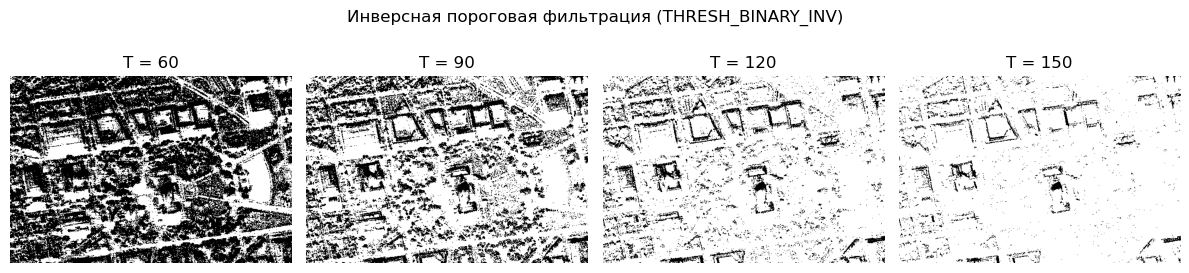

In [18]:
fig, axes = plt.subplots(1, len(thresholds), figsize=(12, 3))

for col, thr in enumerate(thresholds):
    _, th_bin_inv = cv2.threshold(img, thr, 255, cv2.THRESH_BINARY_INV)
    axes[col].imshow(th_bin_inv, cmap='gray', vmin=0, vmax=255)
    axes[col].set_title(f'T = {thr}')
    axes[col].axis('off')

plt.suptitle('Инверсная пороговая фильтрация (THRESH_BINARY_INV)')
plt.tight_layout()
plt.show()